In [302]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import optuna 

import xgboost


train = pd.read_csv("~/kaggledatasets/riiid-test-answer-prediction/train.csv", 
                        nrows=5e6, 
                        dtype={'row_id': 'int64', 
                        'timestamp': 'int64', 
                        'user_id': 'int32', 
                        'content_id': 'int16', 
                        'content_type_id': 'int8',
                        'task_container_id': 'int16', 
                        'user_answer': 'int8', 
                        'answered_correctly': 'int8', 
                        'prior_question_elapsed_time': 'float32', 
                        'prior_question_had_explanation': 'boolean'},
                        )

questions = pd.read_csv("~/kaggledatasets/riiid-test-answer-prediction/questions.csv")
lectures = pd.read_csv("~/kaggledatasets/riiid-test-answer-prediction/lectures.csv")

In [286]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [113]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [114]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [115]:
train[(train.content_type_id == 1)&(train.user_id == 2746)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
89,89,653762,2746,6808,1,14,-1,-1,NaN,False


In [116]:
train[(train.user_id == 2746) & (train.task_container_id == 14)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
89,89,653762,2746,6808,1,14,-1,-1,NaN,False


In [117]:
train.groupby("task_container_id").content_type_id.nunique().sort_values(False).head()

task_container_id
9999    1
4062    1
4061    1
6457    1
4059    1
Name: content_type_id, dtype: int64

In [118]:
train.isna().sum(axis=0)

row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       71445
prior_question_had_explanation    11978
dtype: int64

In [119]:
train.user_id.nunique()

12006

### train and validation split

In [120]:
train.shape

(3000000, 10)

In [123]:
validation = train.groupby("user_id").tail(20)
train = train[~train.index.isin(validation.index)]
print(f"valaidation data percentage={round((validation.shape[0]*100)/train.shape[0], 2)}")

In [124]:
train[train.user_id == 115].tail(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
16,16,398020,115,25,0,16,1,1,21000.0,False
17,17,418008,115,183,0,17,0,0,20000.0,False
18,18,437272,115,7926,0,18,1,1,18000.0,False
19,19,468511,115,7927,0,19,3,1,17000.0,False
20,20,490100,115,4,0,20,1,0,29000.0,False
21,21,510583,115,7984,0,21,3,0,20000.0,False
22,22,534187,115,45,0,22,2,0,19000.0,False
23,23,557677,115,185,0,23,3,0,21000.0,False
24,24,575289,115,55,0,24,3,1,22000.0,False
25,25,597863,115,7876,0,25,3,1,16000.0,False


In [125]:
validation[validation.user_id == 115].head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
26,26,621464,115,6,0,26,2,1,20000.0,False
27,27,645415,115,172,0,27,1,1,22000.0,False
28,28,670520,115,7898,0,28,2,1,22000.0,False
29,29,692971,115,175,0,29,0,0,23000.0,False
30,30,710402,115,100,0,30,0,1,20000.0,False
31,31,732421,115,7859,0,31,3,0,15000.0,False
32,32,1219624,115,57,0,32,0,1,20000.0,False
33,33,1252621,115,7948,0,33,0,1,20000.0,True
34,34,1284094,115,151,0,34,3,1,22000.0,True
35,35,1320874,115,167,0,35,2,1,19000.0,True


In [126]:
validation.isna().sum(axis=0)

row_id                               0
timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
user_answer                          0
answered_correctly                   0
prior_question_elapsed_time       4645
prior_question_had_explanation    1874
dtype: int64

In [127]:
len(set(validation.user_id) - set(train.user_id))

1874

In [128]:
len(set(train.user_id) - set(validation.user_id))

0

In [129]:
train.isna().sum(axis=0)

row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       66800
prior_question_had_explanation    10104
dtype: int64

In [130]:
train.user_id.nunique()

10132

In [131]:
elapsed_time = train.prior_question_elapsed_time.mean()

In [132]:
elapsed_time

25602.939453125

In [133]:
train.prior_question_elapsed_time.fillna(elapsed_time, inplace=True)

In [134]:
validation.prior_question_elapsed_time.fillna(elapsed_time, inplace=True)

In [135]:
train.prior_question_had_explanation.fillna(False, inplace=True)
validation.prior_question_had_explanation.fillna(False, inplace=True)

In [136]:
validation.isna().sum(axis=0)

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [137]:
train.isna().sum(axis=0)

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [138]:
train.prior_question_elapsed_time.mean()

25594.708984375

In [139]:
validation.prior_question_elapsed_time.mean()

23589.150390625

## Feature Engineering

In [96]:
te_content_id = train.groupby("content_id").agg({"answered_correctly": ['mean', 'count']})

In [97]:
te_content_id.columns = ["_".join(i) for i in te_content_id.columns]

In [99]:
te_content_id.columns = ["content_id_mean", "content_id_count"]

In [100]:
te_content_id.head()

,content_id_mean,content_id_count
content_id,,
0,0.894737,152
1,0.926667,150
2,0.553863,919
3,0.794521,438
4,0.641538,650


In [101]:
train = pd.merge(train, te_content_id, left_on = 'content_id', right_index=True, how='left')

In [105]:
train[train.content_id_count == 1]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,te_content_id,content_id_mean,content_id_count
1038,1038,15096596851,13134,12402,0,335,3,0,32666.0,True,0.0,0.0,1
1039,1039,15096596851,13134,12404,0,335,3,0,32666.0,True,0.0,0.0,1
1040,1040,15096596851,13134,12403,0,335,1,0,32666.0,True,0.0,0.0,1
1865,1865,17803115295,13134,12691,0,1038,0,1,11000.0,True,1.0,1.0,1
26473,26473,525475776,475020,12979,0,396,3,1,27000.0,True,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826366,1826366,465740261,38712921,12629,0,25,2,1,24000.0,True,1.0,1.0,1
1913998,1913998,1296191253,40202723,12914,0,58,3,0,26000.0,True,0.0,0.0,1
1945714,1945714,1496054377,40598068,13029,0,60,3,1,22333.0,True,1.0,1.0,1
1945715,1945715,1496054377,40598068,13030,0,60,0,1,22333.0,True,1.0,1.0,1


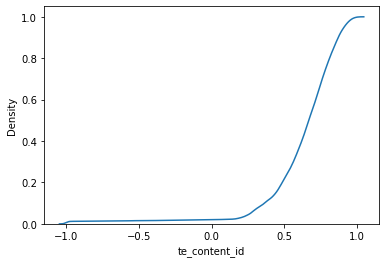

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(train.te_content_id, cumulative=True)
plt.show()

In [145]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth), smooth

In [142]:
train_lectures = train[train.content_type_id == 1]
train = train[train.content_type_id == 0]

validation_lectures = validation[validation.content_type_id == 1]
validation = validation[validation.content_type_id == 0]

In [203]:
train["te_content_id"], smooth_content_id = calc_smooth_mean(train, by="content_id", on="answered_correctly", m=30)

In [204]:
smooth_content_id.name = 'te_content_id'

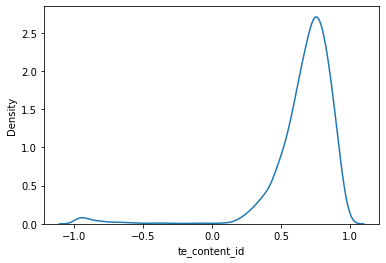

In [299]:
sns.kdeplot(dp.te_content_id, cumulative=False)
plt.show()

In [206]:
validation = pd.merge(validation, smooth_content_id, left_on='content_id', right_index=True, how='left')

In [208]:
train['te_task_container_id'], smooth_task_container = calc_smooth_mean(train, by="task_container_id", on="answered_correctly", m=30) 

In [209]:
smooth_task_container.name = 'te_task_container_id'

In [210]:
validation = pd.merge(validation, smooth_task_container, left_on='task_container_id', right_index=True, how='left')

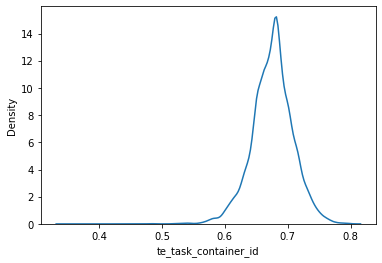

In [211]:
sns.kdeplot(smooth_task_container, cumulative=False)
plt.show()

In [305]:
class DataPipeline:
    def __init__(self, data, m_content_id, m_task_container_id, ):
        # self.data = data
        self.train = data
        self.validation = None
        self._split_train_validation()
        self.te_content_id = None
        self.te_task_container_id = None
        self.elapsed_mean = None
        self.elapsed_mean = self.train.prior_question_elapsed_time.mean()
        self.train = self.clean_impute(self.train)
        self.validation = self.clean_impute(self.validation)
        self._feature_engineering_utils(m_content_id, m_task_container_id)
        self.is_state_reset = False
        self.usefull_columns = ['user_id',
                                'timestamp',
                               'content_id',
                               'task_container_id',
                               'prior_question_elapsed_time',
                               'prior_question_had_explanation',
                               'te_content_id', 
                               'te_task_container_id',
                                "answered_correctly",
                               ]
                                    
                                    
    def _split_train_validation(self):
        self.validation = self.train.groupby("user_id").tail(20)
        self.train = self.train[~self.train.index.isin(self.validation.index)]
        print(f"valaidation data percentage={round((self.validation.shape[0]*100)/self.train.shape[0], 2)}")

    def _feature_engineering_utils(self, m_content_id, m_task_container_id):
        self.te_content_id = self._calc_smooth_mean(by="content_id", on="answered_correctly", m=m_content_id)
        self.te_task_container_id = self._calc_smooth_mean(by="task_container_id", 
                                                          on="answered_correctly", 
                                                          m=m_task_container_id
                                                         )
        self.te_content_id.name = "te_content_id"
        self.te_task_container_id.name = "te_task_container_id"
        # self.elapsed_mean = self.train.prior_question_elapsed_time.mean()
        
        # self.train = self.train[self.train.content_type_id == 0]
        # self.validation = self.validation[self.validation.content_type_id == 0]

    def _calc_smooth_mean(self, by, on, m):
        # Compute the global mean
        mean = self.train[on].mean()
        # Compute the number of values and the mean of each group
        agg = self.train.groupby(by)[on].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        # Compute the "smoothed" means
        smooth = (counts * means + m * mean) / (counts + m)
        return smooth
    
    
    def clean_impute(self, data):
        data = data[data.content_type_id == 0]
        data.prior_question_elapsed_time.fillna(self.elapsed_mean, inplace=True)
        data.prior_question_had_explanation.fillna(False, inplace=True)
        return data
    
    def get_train_data(self):
        # self.train = self.clean_impute(self.train)
        self.train = pd.merge(self.train, self.te_content_id, left_on = 'content_id', right_index=True, how='left')
        self.train = pd.merge(self.train, self.te_task_container_id, left_on = 'task_container_id', right_index=True, how='left')
        self.train = self.train.loc[:, self.usefull_columns]
        return self.train
        
    def get_validation_data(self):
        # self.validation = self.clean_impute(self.validation)
        self.validation = pd.merge(self.validation, self.te_content_id, left_on = 'content_id', right_index=True, how='left')
        self.validation = pd.merge(self.validation, self.te_task_container_id, left_on = 'task_container_id', right_index=True, how='left')
        self.validation = self.validation.loc[:, self.usefull_columns]
        return self.validation
        
    def get_test_data(self, test):
        test = self.clean_impute(test)
        test = pd.merge(test, self.te_content_id, left_on = 'content_id', right_index=True, how='left')
        test = pd.merge(test, self.te_task_container_id, left_on = 'task_container_id', right_index=True, how='left')
        test = test.loc[:, self.usefull_columns]
        return test
    
    def reset_state(self, data):
        self.train = data
        self.is_state_reset = True
        self.te_content_id = self._calc_smooth_mean(by="content_id", on="answered_correctly", m=m_content_id)
        self.te_task_container_id = self._calc_smooth_mean(by="task_container_id", 
                                                          on="answered_correctly", 
                                                          m=m_task_container_id
                                                         )
        self.elapsed_mean = self.train.priot_question_elapsed_time.mean()
        


In [306]:
dp = DataPipeline(train, 10, 10)

valaidation data percentage=8.16


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [307]:
train.shape

(5000000, 10)

In [308]:
train_cleaned = dp.get_train_data()

In [309]:
train_cleaned.head()

,user_id,timestamp,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,te_content_id,te_task_container_id,answered_correctly
0,115,0,5692,1,25666.021484,False,0.734951,0.527289,1
1,115,56943,5716,2,37000.000000,False,0.747220,0.437600,1
2,115,118363,128,0,55000.000000,False,0.971427,0.704253,1
3,115,131167,7860,3,19000.000000,False,0.956809,0.568627,1
4,115,137965,7922,4,11000.000000,False,0.950275,0.485104,1


In [310]:
validation_cleaned = dp.get_validation_data()

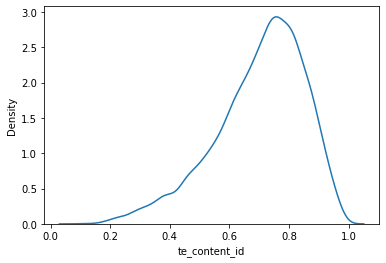

In [311]:
sns.kdeplot(dp.te_content_id, cumulative=False)
plt.show()

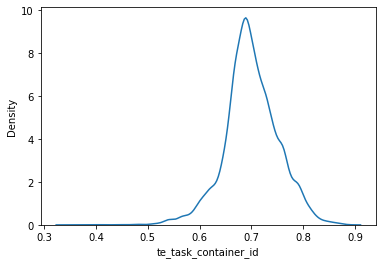

In [312]:
sns.kdeplot(dp.te_task_container_id, cumulative=False)
plt.show()

In [270]:
train.isna().sum(axis=0)

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
te_content_id                     0
te_task_container_id              0
dtype: int64

In [314]:
validation_cleaned[validation_cleaned.te_task_container_id.isna()]

,user_id,timestamp,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,te_content_id,te_task_container_id,answered_correctly
1896750,39919444,24925459471,10652,9992,20000.0,True,0.775706,NaN,0
1896752,39919444,24925509115,10405,9994,21000.0,True,0.643023,NaN,1
1896753,39919444,24925532584,10475,9995,13000.0,True,0.712675,NaN,1
1896755,39919444,24925575203,10470,9997,15000.0,True,0.771553,NaN,1
1896757,39919444,24925609370,7979,9999,19000.0,True,0.772614,NaN,1
1929133,40224694,31283183059,5151,9992,16000.0,True,0.666512,NaN,1
1929134,40224694,31283215827,3683,9993,15000.0,True,0.882763,NaN,1
1929135,40224694,31283235735,9723,9994,21000.0,True,0.850742,NaN,1
1929136,40224694,31283260736,5726,9995,6000.0,True,0.683722,NaN,0
1929137,40224694,31283271098,5646,9996,11000.0,True,0.824676,NaN,1


In [315]:
dp.te_task_container_id[dp.te_task_container_id == 9992]

Series([], Name: te_task_container_id, dtype: float64)

In [316]:
train.task_container_id.nunique()

10000

In [317]:
train_cleaned.task_container_id.nunique()

9992

In [318]:
validation_cleaned.task_container_id.nunique()

4547